# 2. Data preparation for the Poisson process

In this notebook, we process the raw data to produce meaningful analysis.

In section 1, we import that data, check and recast the `dtypes`, and then process the date and time of each email.

In [1]:
from scipy.stats import poisson, expon, norm, bernoulli
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from math import sqrt

## 1. Data import and preparation

The date needs to be wrangled so we can answer the questions.

In [2]:
# load the dataset
df = pd.read_csv("email_log.csv")

In [3]:
df.head()

,DATE,TIME
0,2020-01-01,09:02:27
1,2020-01-01,09:03:50
2,2020-01-01,09:06:31
3,2020-01-01,09:09:16
4,2020-01-01,09:15:11


In [4]:
df.dtypes

DATE    object
TIME    object
dtype: object

The **DATE** and **TIME** attributes have come through as `objects`.
Let us recast them to `datetime64`.

In [5]:
# convert the DATE and TIME to DATETIME
df["DATE"] = pd.to_datetime(df["DATE"])
df["TIME"] = pd.to_datetime(df["TIME"])

In [6]:
df.head()

,DATE,TIME
0,2020-01-01,2021-01-08 09:02:27
1,2020-01-01,2021-01-08 09:03:50
2,2020-01-01,2021-01-08 09:06:31
3,2020-01-01,2021-01-08 09:09:16
4,2020-01-01,2021-01-08 09:15:11


In [7]:
df.dtypes

DATE    datetime64[ns]
TIME    datetime64[ns]
dtype: object

The Poisson process works in continuous time.
However, there are gaps in the data (between 5pm and 9am).

Let us introduce some new fields so we can measure the data in continuous time.

- **DAY**
    - As `int`, a count from in the days since the origin date.
- **HOUR**
    - As `int`, the hour the email is received with range $(0, 7)$, so
        - 9am $\to$ 0
        - 10am $\to$ 1
        - $\dots$
- **MINUTE**
    - As `int`, the minute the email is received.
- **SECOND**
    - As `int`, the seconds the email is received.

In [8]:
# set the origin data
START_DAY = pd.to_datetime("2020-01-01")

# subtract the origin from the current date
df["DAY"] = df["DATE"] - START_DAY

In [9]:
df.dtypes

DATE     datetime64[ns]
TIME     datetime64[ns]
DAY     timedelta64[ns]
dtype: object

**DAY** is now of dtype `timedelta64`.
Recast in to `int64` so we can manipulate it for calculations.

In [10]:
# recast DAY
df["DAY"] = df["DAY"].dt.days.astype('int64')

# get TIME.hour of TIME as int
df["HOUR"] = df["TIME"].dt.hour.astype('int64')

# reindex 9.00-17.00 to 00.00-08.00
df["HOUR"] = (df["HOUR"] - 1) % 8

# recast TIME.minute to int
df["MINUTE"] = df["TIME"].dt.minute.astype('int64')

# recast TIME.second to int
df["SECOND"] = df["TIME"].dt.second.astype('int64')

In [11]:
df.head()

,DATE,TIME,DAY,HOUR,MINUTE,SECOND
0,2020-01-01,2021-01-08 09:02:27,0,0,2,27
1,2020-01-01,2021-01-08 09:03:50,0,0,3,50
2,2020-01-01,2021-01-08 09:06:31,0,0,6,31
3,2020-01-01,2021-01-08 09:09:16,0,0,9,16
4,2020-01-01,2021-01-08 09:15:11,0,0,15,11


In [12]:
df.dtypes

DATE      datetime64[ns]
TIME      datetime64[ns]
DAY                int64
HOUR               int64
MINUTE             int64
SECOND             int64
dtype: object

**TIME** is set to today's date due to the way `pandas` handles `datetimes`.
This is safe to ignore.
The data is now ready.

## 2. Number of emails per hour

Let us create a new view of the data that has the following attributes:

- $X$: The number of emails received in an hour.
- $f$: The frequency of $X$.

In [13]:
# add a key: dd-hh
df["KEY"] = df["DAY"].astype("str") + "-" + df["HOUR"].astype("str")

# group-by KEY, and count the rows that posses the KEY
v_emails_per_hour = df.groupby(by=["KEY"]).count()
v_emails_per_hour.reset_index(inplace=True)

Let us tidy up the view to make it more legible.
(This is optional).

In [14]:
# columns to drop
v_emails_per_hour.drop(columns=["DATE",
                                "TIME",
                                "DAY",
                                "MINUTE",
                                "SECOND"],
                       inplace=True)

# rename column
v_emails_per_hour.rename(columns={"HOUR": "X"}, inplace=True)

In [15]:
v_emails_per_hour.head()

,KEY,X
0,0-0,13
1,0-1,13
2,0-2,20
3,0-3,15
4,0-4,14


Now let us count the frequency of each X.

In [16]:
v_number_of_emails = v_emails_per_hour.groupby(by="X").count()

Let us again tidy up the view.
(This is again optional).

In [17]:
# reset the index
v_number_of_emails.reset_index(inplace=True)

# rename the column
v_number_of_emails.rename(columns={"KEY": "f"}, inplace=True)

In [18]:
v_number_of_emails.head()

,X,f
0,2,1
1,4,2
2,5,4
3,6,10
4,7,18


Now let us plot the view of Number of emails per hour.

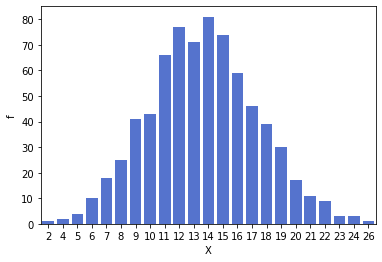

In [19]:
sns.barplot(data=v_number_of_emails,
            x="X",
            y="f",
            color="royalblue")
plt.show()

Another property of a Poisson distribution is that the $E(X) = V(X)$.
Let us check this is the case for the data.

In [20]:
mean_number = v_emails_per_hour["X"].mean()
mean_number

13.633378932968537

In [21]:
# use ddof=1 so we calculate the sample var
var_number = v_emails_per_hour["X"].var(ddof=1)
var_number

13.95855555347338

## 3. Rate of emails remains constant

We need to produce a simple "TIME RECEIVED" against "EVENT" scattergraph.
Let us first get the timestamp (in hours passed since the origin).

First we convert each of **DAY**, **MINUTE**, and **SECOND** into unit decimal hours.

In [22]:
v_rate_of_emails = pd.DataFrame()

HOURS_PER_DAY = 8  # There are 8 hours in a working day.
HOURS_PER_MINUTE = 1 / 60  # A minute is 1/60 hours
HOURS_PER_SECONDS = 1/3600  # A second is 1/3600 hours

v_rate_of_emails["DAY (HH)"] = df["DAY"] * HOURS_PER_DAY
v_rate_of_emails["HOUR (HH)"] = df["HOUR"]
v_rate_of_emails["MINUTE (HH)"] = df["MINUTE"] * HOURS_PER_MINUTE
v_rate_of_emails["SECOND (HH)"] = df["SECOND"] * HOURS_PER_SECONDS

We can now get the time stamp in hours passed since the origin by summing the four new attributes.

In [23]:
v_rate_of_emails["TIME (HH)"] = (v_rate_of_emails["DAY (HH)"] +
                                 v_rate_of_emails["HOUR (HH)"] +
                                 v_rate_of_emails["MINUTE (HH)"] +
                                 v_rate_of_emails["SECOND (HH)"])

In [24]:
v_rate_of_emails.head()

,DAY (HH),HOUR (HH),MINUTE (HH),SECOND (HH),TIME (HH)
0,0,0,0.033333,0.007500,0.040833
1,0,0,0.050000,0.013889,0.063889
2,0,0,0.100000,0.008611,0.108611
3,0,0,0.150000,0.004444,0.154444
4,0,0,0.250000,0.003056,0.253056


Let us add an event label to the view.
This will be the value each point takes measured against the $y-$axis.

In [25]:
# get size of DataFrame
length = v_rate_of_emails["TIME (HH)"].size + 1

# create the series
a_range = np.arange(start=1, stop=length, step=1)

# append a_range to tmp
v_rate_of_emails["EVENT"] = a_range

Tidy up the view.
(This is optional).

In [26]:
v_rate_of_emails.drop(columns=["DAY (HH)",
                               "HOUR (HH)",
                               "MINUTE (HH)",
                               "SECOND (HH)"],
                      inplace=True)

In [27]:
v_rate_of_emails.head()

,TIME (HH),EVENT
0,0.040833,1
1,0.063889,2
2,0.108611,3
3,0.154444,4
4,0.253056,5


Plot the time series.

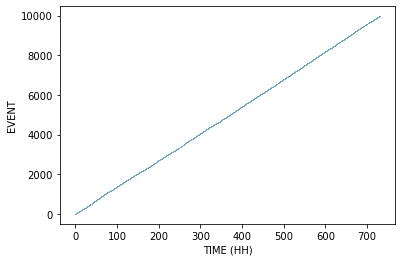

In [28]:
sns.scatterplot(data=v_rate_of_emails,
                x="TIME (HH)",
                y="EVENT",
                alpha=1,
                s=1)
plt.show()

## 4. Waiting time between emails

We'll make use of the view from the rate of emails section, introducing a new attribute that measures the time past (in hours) between successive events.
We use the `shift()` method to compare successive time stamps.

In [29]:
v_waiting_time = pd.DataFrame()

a_waiting_time = (v_rate_of_emails["TIME (HH)"] -
                  v_rate_of_emails["TIME (HH)"].shift(1))

# first entry will be NaN, as there is nothing to compare it with.
a_waiting_time.dropna(inplace=True)

Let us plot a histogram of the waiting times.

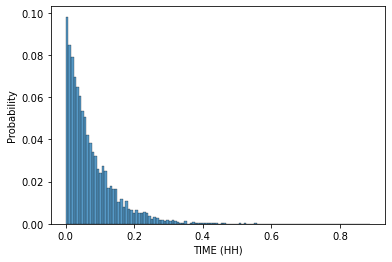

In [30]:
sns.histplot(data=a_waiting_time, stat="probability")
plt.show()

Another property of a exponential distribution is that the $E(X) \approx S(X)$.

In [31]:
mean_waiting = a_waiting_time.mean()
mean_waiting

0.0732616937057479

In [32]:
std = a_waiting_time.std(ddof=1)
std

0.07229715684157634

## 5. Point estimate of $\lambda$

The maximumum likelihood estimator for the Poisson parameter $\widehat \lambda_{X}$ is

$$
\widehat \lambda_{X} = \overline X,
$$

and the MLE for the exponential parameter $\widehat \lambda_{T}$ is

$$
\widehat \lambda_{T} = \frac{1}{\overline T}.
$$

It should be that $\widehat \lambda_{X} \approx \widehat \lambda_{T}$.

We have two ways to estimate it here: The number of emails per hour and the waiting time between emails.
Let us calculate it using both datasets.

We have already calculated the expected number of emails per hour.

In [33]:
mean_number

13.633378932968537

Therefore, we propose that $\widehat \lambda_{X}$ is approximately 13.6.

In [34]:
rate_number = mean_number

We have also already calculated the expected waiting time between emails.

In [35]:
mean_waiting

0.0732616937057479

Therefore, we propose that $\widehat \lambda_{T}$ is approximately...

In [36]:
rate_waiting = 1 / mean_waiting
rate_waiting

13.649698081188955

## 6. Confidence interval for $\lambda$

We now need some parameters:

- $\overline x$
- $z$
- $n$

In [40]:
# get z
z = round(norm().ppf(q=0.975), 3)
z

1.96

In [41]:
# get n
n = v_sample.index.values.size
n

731

Calculate the confidence interval

In [44]:
# mu minus
mean_number - (z*sqrt(mean_number/n))

13.36570928003078

In [45]:
# mu plus
mean_number + (z*sqrt(mean_number/n))

13.901048585906294